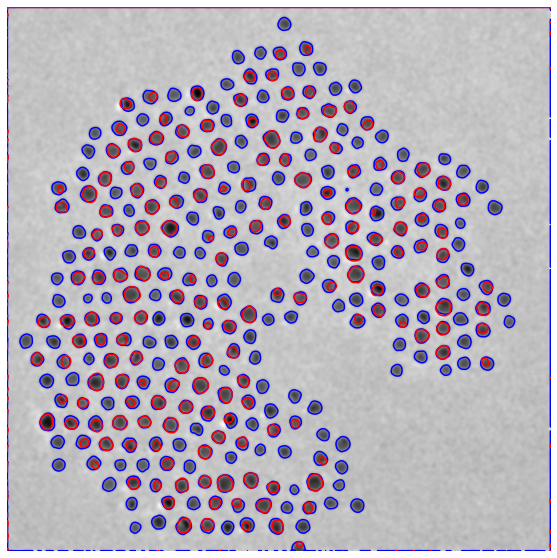

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
from skimage import filters, measure, segmentation, morphology
import pandas as pd
import os
import glob
import time
from scipy import optimize, stats
import seaborn as sns
import warnings
from scipy import special
from scipy.special import jv
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline, UnivariateSpline,LSQUnivariateSpline, splrep, splev
from scipy import ndimage
import statsmodels.api as sm
import time
from bayes_opt import BayesianOptimization
import evap_functions as ef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



######### Useful Functions and Values #########
D_nm = 3.81e5 ##nm^2 / s
D_m = 3.81e-13 ## m^2/s
omega_nm = 1.69e-3 ##nm^3
omega_m = 1.69e-29 ## m^3
m_Au = 3.27e-25 ## kg/atom
Vm = 1.02e-5 ## m^3 / mol
kB = 1.38e-23 ## J/K
R = 8.314 ## J/molK
gamma = 1.5 ## J/m^2
p900 = 4.9e-4 ## Pa
theta_experiment = 2 ## radians -- ~120 degrees
T_experiment = 900 ## celcius
alpha_GT = 2 * gamma * Vm / (R * T_experiment)

def alpha(theta):
    return np.pi / 3 * (2 - 3 * np.cos(theta) + np.cos(theta)**3)

def beta(theta):
    return 4 * np.pi * (1 - np.cos(theta))

def p_bulk(T_kelvin):
    ln_p = 14.158 - 19343/T_kelvin - 0.7479 * np.log(T_kelvin)
    return np.exp(ln_p)

def M(alpha,T=T_experiment):
    return alpha * omega_m / np.sqrt(2 * np.pi * m_Au * kB * (T_experiment + 273))

def fit_trajectories(particle_set,particle_info,cutoff_time,bounds,x0,function,residuals,plot=False,n_plot=2,check_length=False,rand_frac=0.25):
    params = []
    if plot:
        f,a = plt.subplots(figsize=(20,10),ncols=2)
    colors = plt.cm.Set1(np.linspace(0,1,10))
    n = 0
    
    for particle in particle_set:
        if plot:
            if n > n_plot:
                break
            if np.random.rand() > rand_frac:
                continue
        
        else:
            if n % 25 == 0:
                print('particle: {} / {}'.format(n,len(particle_set)))
        
        p = particle_info.get_group(particle)
        if check_length:
            if len(p) < 5:
                continue
                
        r = np.array(p['d'] / 2)
        t = np.array(p['time'])
        
        time_cutoff = int(cutoff_time / 5)
        if len(t[time_cutoff:]) < 50:
            continue
            
        w = np.ones_like(t)
        w[0] = 10
        w[-1] = 10
        w[time_cutoff:] = 2
        spl = UnivariateSpline(t,r,w=w,k=5,s=1)
        deriv = spl.derivative()
        try:
            fit = optimize.least_squares(residuals,x0=x0,args=(spl(t[time_cutoff:]),deriv(t[time_cutoff:])),
                                        bounds=bounds,max_nfev=10000,verbose=0,xtol=None,loss='linear')
        except ValueError:
            print('Bad')
            continue
        
        if plot:
            x = np.linspace(0.25,2.5,1000)
            a[0].plot(t,r,color=colors[n])
            a[0].plot(t,spl(t),color=colors[n],linewidth=3,label=particle)
            a[1].scatter(spl(t[time_cutoff::10]),deriv(t[time_cutoff::10]),color=colors[n],linewidth=3)
            a[1].plot(x,model(x,*fit.x),label=particle,color=colors[n],linewidth=3)
        
        params.append(fit.x)
        n += 1
        
    if plot:
        a[0].legend()
        a[0].set_ylim([0,2.5])
        
        a[1].set_ylim([-1e-2,0.5e-3])
        a[1].set_xlim([0,2])
        
        a[0].set_ylabel('R [nm]',fontsize=20)
        a[0].set_xlabel('time [s]',fontsize=20)
        
        a[1].set_xlabel('R [nm]',fontsize=20)
        a[1].set_ylabel('dR/dt [nm/s]',fontsize=20)
        
    return params

def scatterplot_data(particle_set,particle_info,cutoff_frame):

    all_drdt = []
    all_r = []
    all_t = []
    
    time_cutoff = int(cutoff_frame / 5)
    
    for particle in particle_set:#[59]:
        p = particle_info.get_group(particle)
        r = np.array(p['d'] / 2)
        t = np.array(p['time'])
        
        t_cut = t[time_cutoff:]
        if len(t_cut) < 50:
            continue
                
        w = np.ones_like(t)
        w[0] = 10
        w[-1] = 10
        w[time_cutoff:] = 2
        spl = UnivariateSpline(t,r,w=w,k=5,s=1)
        deriv = spl.derivative()
        for i in t[time_cutoff:]:
            all_r.append(spl(i))
            all_drdt.append(deriv(i))
            all_t.append(i)
            
    return np.array(all_drdt), np.array(all_r), np.array(all_t)
##########################


########## Model ##########

def model(r,A1,A2,A3,A4,A5,theta,xi):
    arg = r * np.sin(theta) / xi
    k1 = special.kn(1,arg)
    k0 = special.kn(0,arg)

    return A1 * (np.sin(theta)) / (xi * alpha(theta) * r) * (k1 / k0) * (A2 + A3 / (r * np.sin(theta))) + A4 * beta(theta) / alpha(theta) * (1 + A5 / r)

def residuals(params,x,y):
    return model(x,*params) - y

def dRdt_evap(r,A4,A5,theta):
    return A4 * beta(theta) / alpha(theta) * (1 + A5 / r)

def evap_residuals(params,x,y):
    return dRdt_evap(x,*params) - y

def dRdt_evap_new(r,A4,A5,theta):
    return A4 * beta(theta)/alpha(theta) * (-1 + A5 / r)

def dRdt_diff(r,A1,A2,A3,theta,xi):
    arg = r * np.sin(theta) / xi
    k1 = special.kn(1,arg)
    k0 = special.kn(0,arg)

    return A1 * (np.sin(theta)) / (xi * alpha(theta) * r) * (k1 / k0) * (A2 + A3 / (r * np.sin(theta)))

def model_new(r,A1,A2,A3,A4,A5,theta,xi):
    arg = r * np.sin(theta) / xi
    k1 = special.kn(1,arg)
    k0 = special.kn(0,arg)
    

    return A1 * (np.sin(theta)) / (xi * alpha(theta) * r) * (k1 / k0) * (A2 + A3 / (r * np.sin(theta))) + A4 * beta(theta) / alpha(theta) * (-1 + A5 / r)

def residuals_new(params,x,y):
    return model_new(x,*params) - y

###########################

data = np.load('/home/leenav/ExtraDrive3/BNL_032020/G1/G1_900C_out_fixed.npy',mmap_mode='r+')   ## Segmented Images
images = np.load('/home/leenav/ExtraDrive3/BNL_032020/G1/G1_900C_driftcorrect_fixed.npy',mmap_mode='r+')  ## Raw Images
f,a = plt.subplots(figsize=(10,10))
a.imshow(images[0],plt.cm.gray)
a.contour(data[0],[filters.threshold_otsu(data[0])],colors=['blue'])
a.contour(data[-1],[filters.threshold_otsu(data[-1])],colors=['red'],alpha=1)
a.axis('off')

info_linked = pd.read_pickle('tracked_particl_info_fixed.pkl')  ## Load extracted data
info_linked.head()

particles = info_linked.groupby('particle')

In [2]:
#### Collect particles that shrink to use for fitting
small_enough = []
for particle in particles.groups:
    p = particles.get_group(particle)
    if len(p) < 5:
        continue
    r = np.array(p['d'] / 2)
    less = np.where(r[:] < 1.5)[0]
    if len(less) >= 50:
        small_enough.append(particle)
print('Number of particles to fit: {}'.format(len(small_enough)))

Number of particles to fit: 135


### Figure 1

The following cells contain code needed to reproduce Figure 1.  These plots give a general overview of the growth trends in the system and demonstrate the type of data that can be easily extracted from image sets

(-0.5, 3249.5, 3249.5, -0.5)

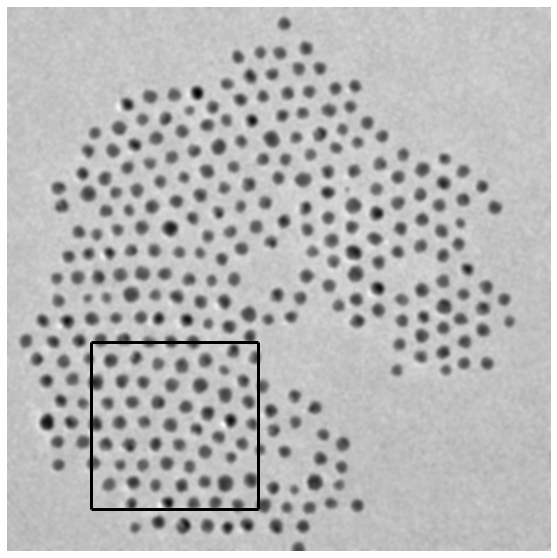

In [3]:
x_min = 2000
x_max = 3000
y_min = 500
y_max = 1500

f,a = plt.subplots(figsize=(10,10))
a.imshow(images[0],plt.cm.gray)
a.hlines([x_min,x_max],y_min,y_max,colors=['black'],linewidths=[3])
a.vlines([y_min,y_max],x_min,x_max,colors=['black'],linewidths=[3])
a.axis('off')

590


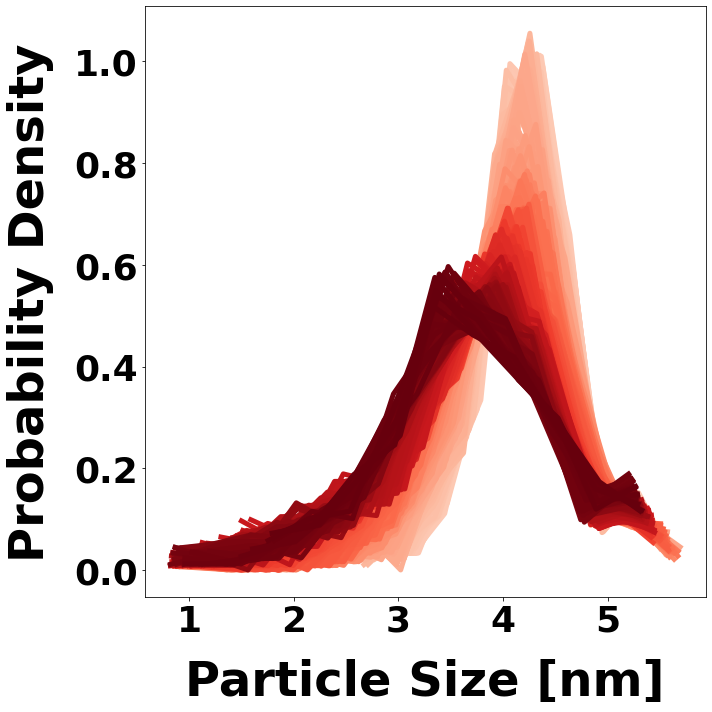

In [4]:
times = info_linked.groupby('time')

f,a = plt.subplots(figsize=(10,10))
n = 0
colors = plt.cm.Reds(np.linspace(0.2,1,590))
for time in times.groups:
    if time >= 0:
    #if time % 100 == 0:
        t = times.get_group(time)
        t=t.loc[t['d'] > 0.25]
        counts,edges = np.histogram(t['d'],bins=10,density=True)
        counts_norm = counts / np.max(counts)
        centers = (edges[:-1] + edges[1:]) / 2
        
        a.plot(centers,counts,color=colors[n],label=time,linewidth=5)
        n += 1
print(n)
#a.set_yticks([])
a.tick_params(axis='both',labelsize=36)
a.set_ylabel('Probability Density',fontsize=48,fontweight='bold',labelpad=20)
a.set_xlabel('Particle Size [nm]',fontsize=48,fontweight='bold',labelpad=20)
a.set_xticks([1,2,3,4,5])

for tick in a.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in a.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
plt.tight_layout()

590


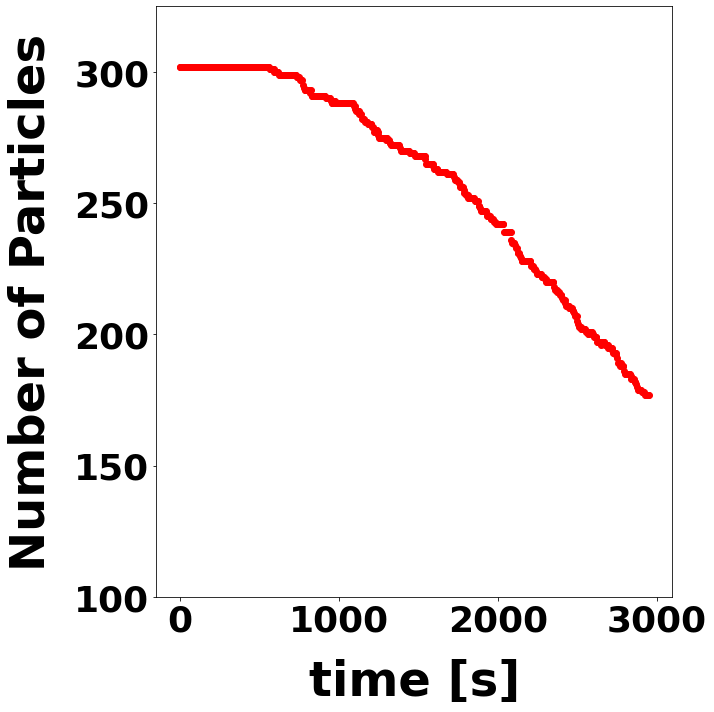

In [5]:
times = info_linked.groupby('time')

f,a = plt.subplots(figsize=(10,10))
n = 0
colors = plt.cm.Reds(np.linspace(0.2,1,590))
for time in times.groups:
    if time >= 0:
        t = times.get_group(time)
        t=t.loc[t['d'] > 0.25]
        counts,edges = np.histogram(t['d'],bins=10,density=True)
        counts_norm = counts / np.max(counts)
        centers = (edges[:-1] + edges[1:]) / 2
        
        a.scatter(time,len(t),color='red')
        n += 1
print(n)

a.tick_params(axis='both',labelsize=36)
a.set_ylabel('Number of Particles',fontsize=48,fontweight='bold',labelpad=20)
a.set_xlabel('time [s]',fontsize=48,fontweight='bold',labelpad=20)

    
for tick in a.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in a.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    
a.set_ylim([100,325])
plt.tight_layout()

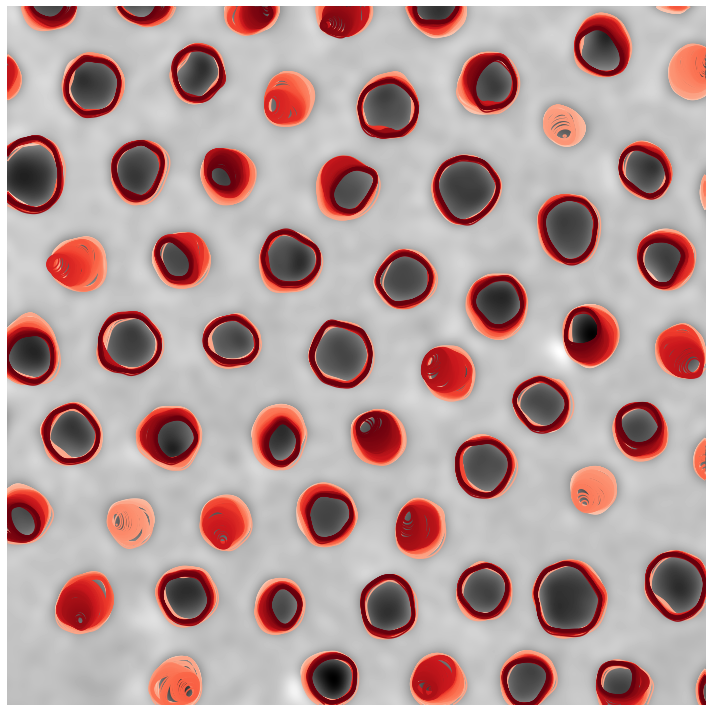

In [6]:
f,a = plt.subplots(figsize=(10,10))
a.imshow(images[0,x_min:x_max,y_min:y_max],plt.cm.gray)
c = plt.cm.Reds(np.linspace(0.2,1,len(data)))
n = 0

for i in range(len(data)):
    if i >= 0:
        a.contour(data[i,x_min:x_max,y_min:y_max],[filters.threshold_otsu(data[i,x_min:x_max,y_min:y_max])],colors=[c[n]])
        n += 1
        
a.axis('off')
plt.tight_layout()

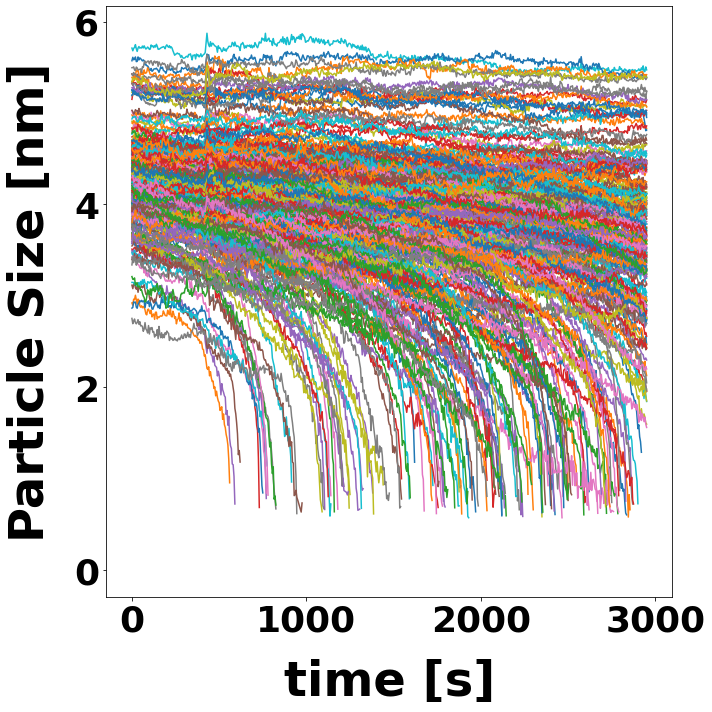

In [7]:
f,a = plt.subplots(figsize=(10,10))
n = 0

for particle in particles.groups:
    p = particles.get_group(particle)
    a.plot(p['time'],p['d'])
    
a.set_xlabel('time [s]',fontsize=48,fontweight='bold',labelpad=20)
a.set_ylabel('Particle Size [nm]',fontsize=48,fontweight='bold',labelpad=20)
a.tick_params(axis='both',labelsize=36)
a.set_yticks([0,2,4,6])

for tick in a.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in a.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')

plt.tight_layout()

### Figure 2

Our model is fit to dR/dt vs R for a sample individual partilce and for all data points.  The following code shows how to fit data, and plot independent components.

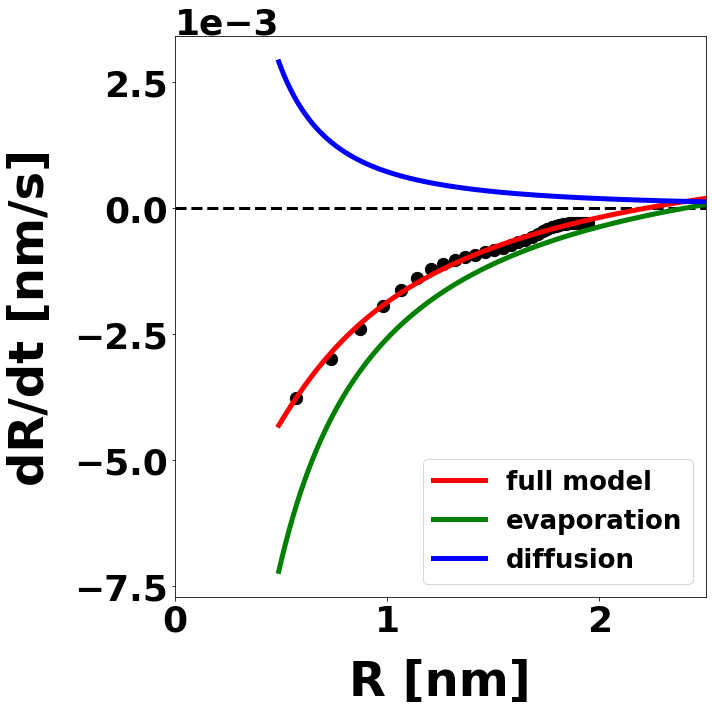

In [8]:
################### Parameter Bounds ##########################
A1_low = 0
A1_high = np.inf

A2_low = -np.inf 
A2_high = np.inf # 0

A3_low = -np.inf
A3_high =  0# 0

A4_low = -np.inf # 0
A4_high = np.inf

A5_low = -np.inf
A5_high =  np.inf # 0

theta_low = np.pi / 2
theta_high = np.pi

xi_low = 0
xi_high = 100

x0 = [100,10,-1,-0.01,1,2,25]

bounds = ([A1_low,A2_low,A3_low,A4_low,A5_low,theta_low,xi_low],[A1_high,A2_high,A3_high,A4_high,A5_high,theta_high,xi_high])
##################################################################

test_particle = particles.get_group(0)
r = np.array(test_particle['d'] / 2)
t = np.array(test_particle['time'])

time_cutoff = int(800 / 5)
    
w = np.ones_like(t)
w[0] = 10
w[-1] = 10
w[time_cutoff:] = 2
spl = UnivariateSpline(t,r,w=w,k=5,s=1)
deriv = spl.derivative()


fit_single = optimize.least_squares(residuals,x0=x0,args=(spl(t[time_cutoff:]),deriv(t[time_cutoff:])),bounds=bounds,max_nfev=10000,verbose=0,xtol=None,loss='linear')

f,a = plt.subplots(figsize=(10,10))
a.scatter(spl(t[time_cutoff::10]),deriv(t[time_cutoff::10]),s=150,color='black')

x = np.linspace(np.min(spl(t[time_cutoff:])),2.5,1000)
a.plot(x,model(x,*fit_single.x),linewidth=5,color='red',label='full model')
a.plot(x,dRdt_evap(x,fit_single.x[3],fit_single.x[4],fit_single.x[5]),linewidth=5,color='green',label='evaporation')
a.plot(x,dRdt_diff(x,fit_single.x[0],fit_single.x[1],fit_single.x[2],fit_single.x[5],fit_single.x[6]),linewidth=5,color='blue',label='diffusion')
legend_properties = {'weight':'bold',
                     'size':26
                    }
a.legend(prop=legend_properties,loc='lower right')
a.set_ylabel('dR/dt [nm/s]',fontsize=48,fontweight='bold',labelpad=20)
a.set_xlabel('R [nm]',fontsize=48,fontweight='bold',labelpad=20)
a.set_yticks([-0.0075,-0.005,-0.0025,0,0.0025])
a.ticklabel_format(axis='y',style='sci',scilimits=[-4,-3],useOffset=True)
a.yaxis.get_offset_text().set_fontsize(36)
a.yaxis.get_offset_text().set_fontweight('bold')
a.tick_params(axis='both',labelsize=36)
a.set_xticks(np.arange(0,2.1,1))
a.hlines([0],0,3,linestyles=['--'],linewidths=[3],colors=['black'])
a.set_xlim([0,2.5])

for tick in a.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in a.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')

plt.tight_layout()

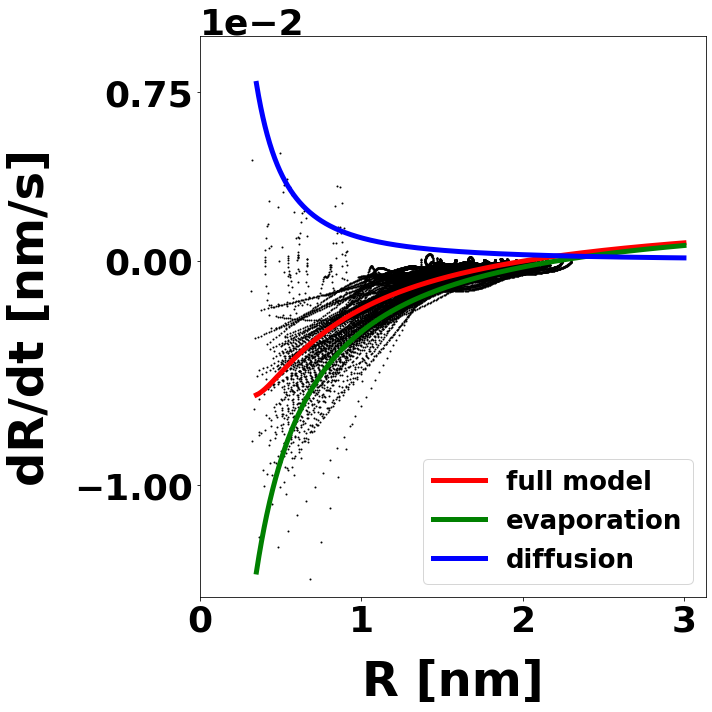

In [9]:
################### Parameter Bounds ##########################
A1_low = 0
A1_high = np.inf

A2_low = -np.inf 
A2_high = np.inf # 0

A3_low = -np.inf
A3_high =  0# 0

A4_low = -np.inf # 0
A4_high = np.inf

A5_low = -np.inf
A5_high =  np.inf # 0

theta_low = np.pi / 2
theta_high = np.pi

xi_low = 0
xi_high = 100

x0 = [100,10,-1,-0.01,1,2,25]

bounds = ([A1_low,A2_low,A3_low,A4_low,A5_low,theta_low,xi_low],[A1_high,A2_high,A3_high,A4_high,A5_high,theta_high,xi_high])
##################################################################
all_drdt, all_r, all_t = scatterplot_data(small_enough,particles,800)

fit = optimize.least_squares(residuals,x0=x0,args=(all_r,all_drdt),bounds=bounds,max_nfev=10000,verbose=0,xtol=None,loss='linear')

f,a = plt.subplots(figsize=(10,10))
a.scatter(all_r,all_drdt,s=1,color='black')

x = np.linspace(0.35,3,1000)
a.plot(x,model(x,*fit.x),color='red',linewidth=5,label='full model')
a.plot(x,dRdt_evap(x,fit.x[3],fit.x[4],fit.x[5]),color='green',linewidth=5,label='evaporation')
a.plot(x,dRdt_diff(x,fit.x[0],fit.x[1],fit.x[2],fit.x[5],fit.x[6]),color='blue',linewidth=5,label='diffusion')

#### Formatting
legend_properties = {'weight':'bold',
                     'size':26
                    }
a.legend(prop=legend_properties,loc='lower right')

a.set_ylabel('dR/dt [nm/s]',fontsize=48,fontweight='bold',labelpad=20)
a.set_xlabel('R [nm]',fontsize=48,fontweight='bold',labelpad=20)
a.set_xticks([0,1,2,3])

a.set_ylim([-0.015,0.0075])
a.set_yticks(np.arange(-0.01,0.011,0.01))
a.set_yticks([-0.01,0,0.0075])
a.ticklabel_format(axis='y',style='sci',scilimits=[-3,-2],useOffset=True)
a.yaxis.get_offset_text().set_fontsize(36)

a.tick_params(axis='both',labelsize=36)

for tick in a.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in a.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    
a.yaxis.get_offset_text().set_fontweight('bold')

    
    
plt.tight_layout()

### Supplemental Figures 1 and 2

Fitting trajectories of all particles to the same model allows us to collect statistics on parameter values.  The first figure below shows the raw fitting output, and the second shows the process for removing outlying fit values

particle: 0 / 135
particle: 25 / 135


<ipython-input-1-c0f3e33eb4b9>:161: RuntimeWarning: invalid value encountered in true_divide
  return A1 * (np.sin(theta)) / (xi * alpha(theta) * r) * (k1 / k0) * (A2 + A3 / (r * np.sin(theta))) + A4 * beta(theta) / alpha(theta) * (1 + A5 / r)


particle: 50 / 135


<ipython-input-1-c0f3e33eb4b9>:161: RuntimeWarning: divide by zero encountered in true_divide
  return A1 * (np.sin(theta)) / (xi * alpha(theta) * r) * (k1 / k0) * (A2 + A3 / (r * np.sin(theta))) + A4 * beta(theta) / alpha(theta) * (1 + A5 / r)


particle: 75 / 135
particle: 100 / 135


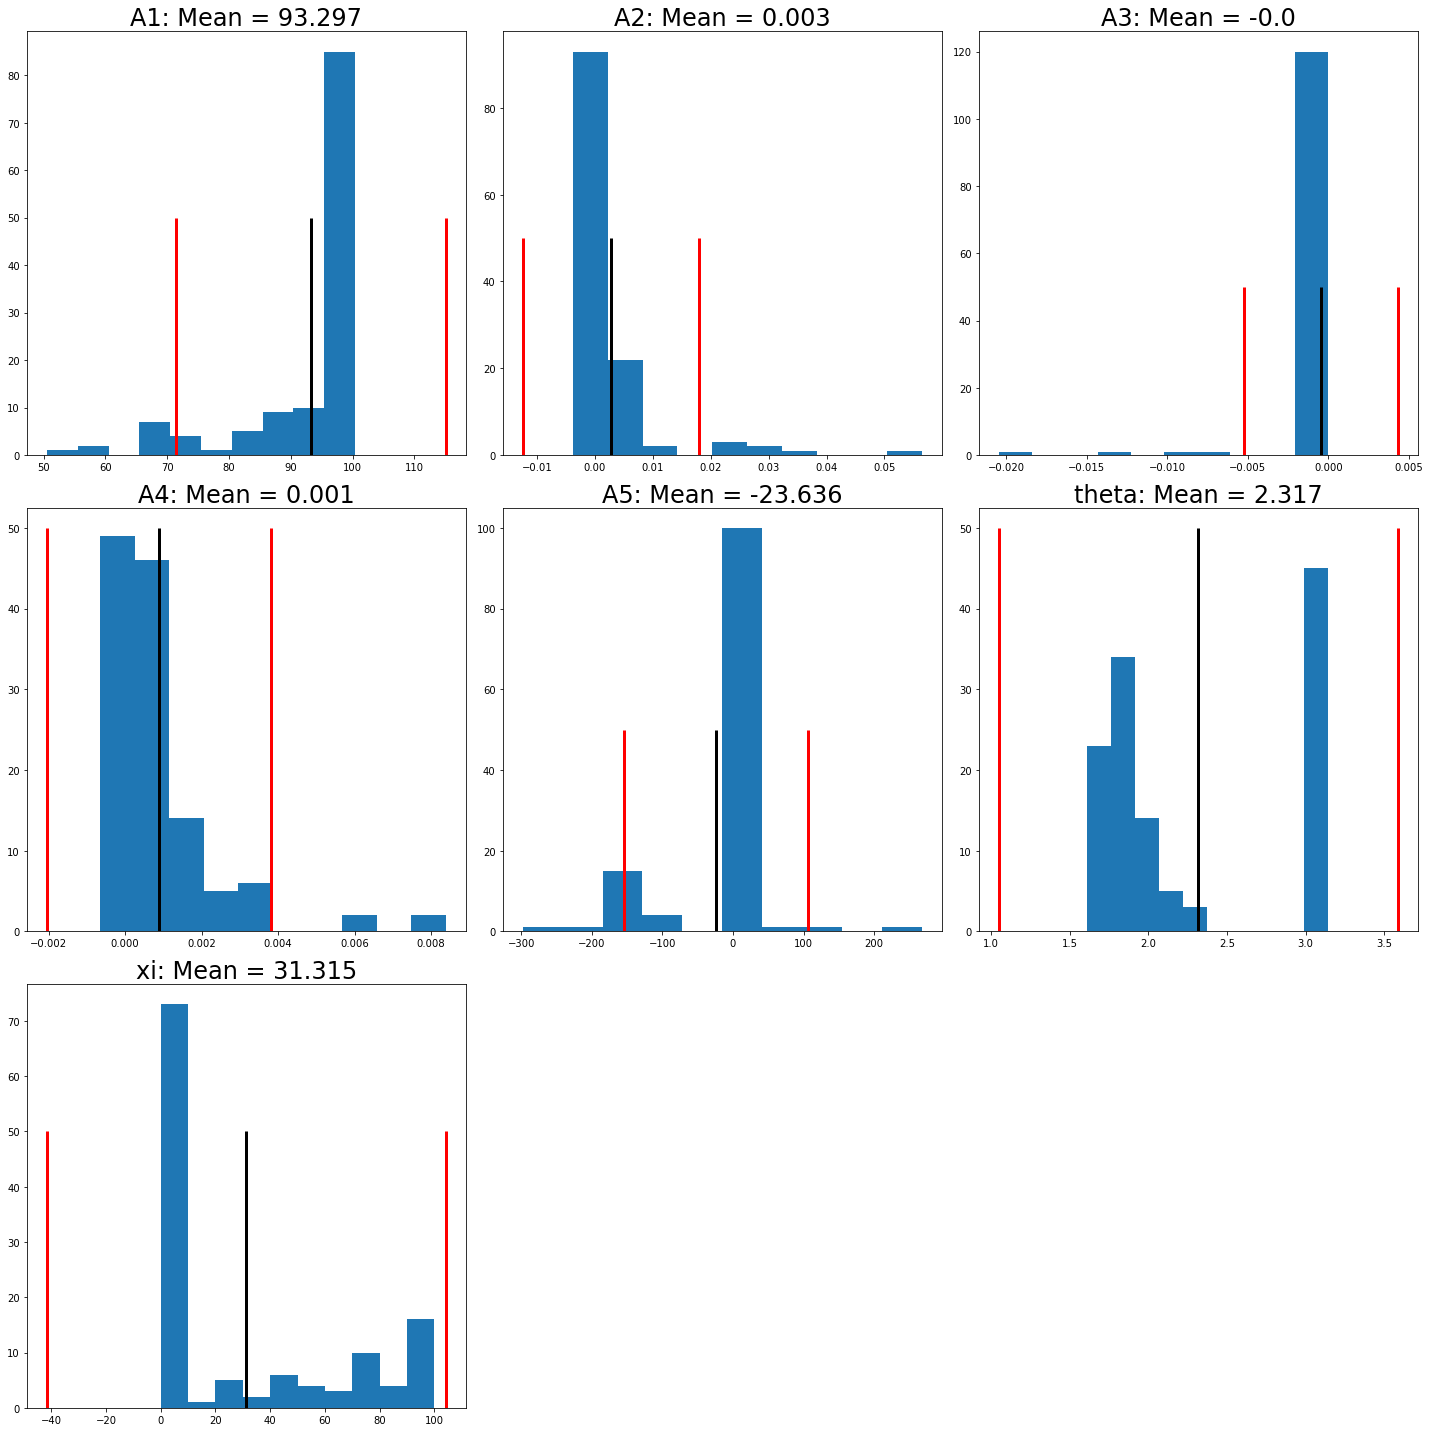

In [10]:
################### Parameter Bounds ##########################
A1_low = 0
A1_high = np.inf

A2_low = -np.inf 
A2_high = np.inf # 0

A3_low = -np.inf
A3_high =  0# 0

A4_low = -np.inf # 0
A4_high = np.inf

A5_low = -np.inf
A5_high =  np.inf # 0

theta_low = np.pi / 2
theta_high = np.pi

xi_low = 0
xi_high = 100

x0 = [100,10,-1,-0.01,1,2,25]

bounds = ([A1_low,A2_low,A3_low,A4_low,A5_low,theta_low,xi_low],[A1_high,A2_high,A3_high,A4_high,A5_high,theta_high,xi_high])
##################################################################


params = fit_trajectories(small_enough,particles,800,bounds,x0,model,residuals)

params_array = np.zeros((len(params),len(params[0])))
for i in range(len(params)):
    params_array[i,:] = params[i]

f = plt.figure(figsize=(20,20))
base = 331
n = 0

names=['A1','A2','A3','A4','A5','theta','xi']

for i in range(params_array.shape[1]):
    ax = f.add_subplot(base+n)
    med = np.median(params_array[:,i])
    mean = np.mean(params_array[:,i])
    std = np.std(params_array[:,i])
    ax.hist(params_array[:,i])
    ax.vlines([np.mean(params_array[:,i])],0,50,linewidths=[3],colors=['black'],label='mean')
    ax.vlines([mean + 2 * std, mean - 2 * std], 0, 50, linewidths=[3],colors=['red'],label='2 std')
    ax.set_title('{}: Mean = {}'.format(names[i],np.round(mean,3)),fontsize=24)
    
    n += 1
plt.tight_layout()

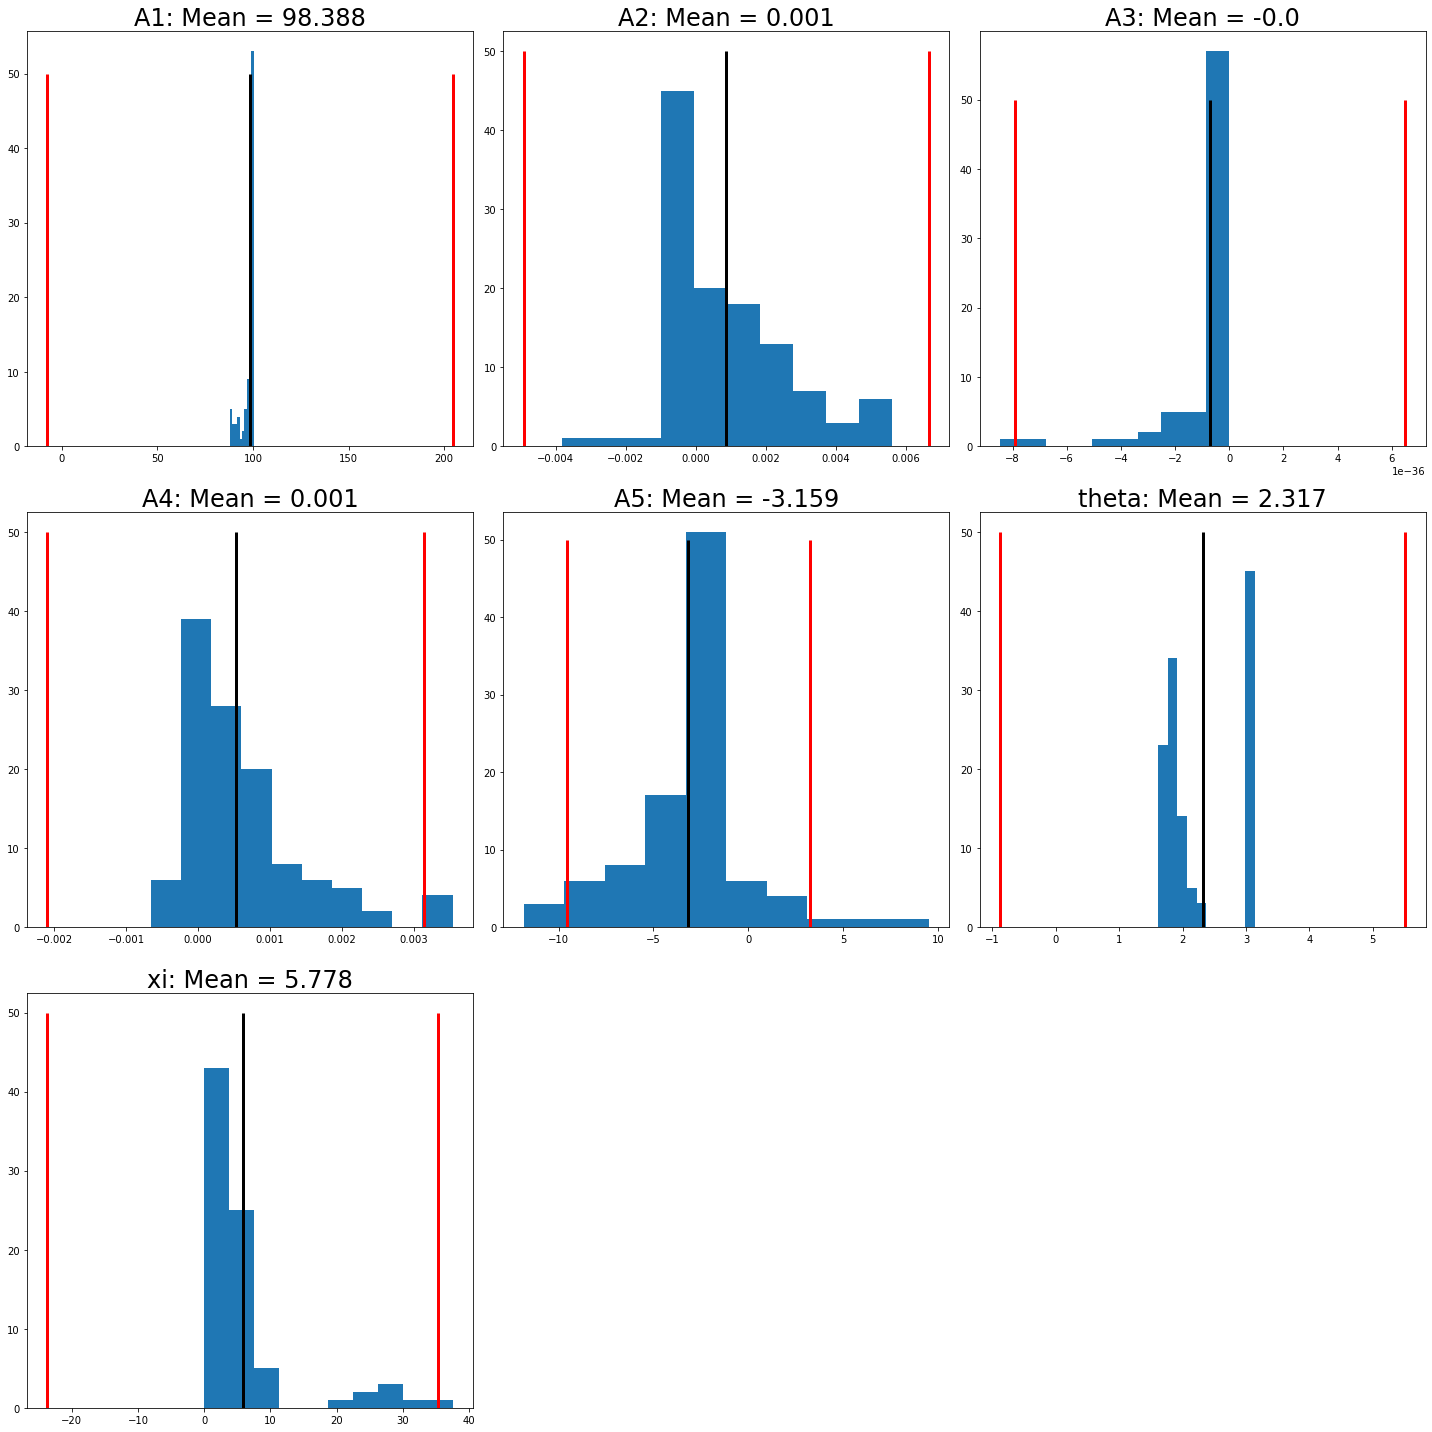

In [11]:
def modified_z(data,threshold,quant = 0.6745):
    mad = stats.median_abs_deviation(data)
    
    mz = (quant / mad) * (data - np.median(data))
    thresh_loc = threshold * mad / quant + np.median(data)
    return mz, thresh_loc




f = plt.figure(figsize=(20,20))
base = 331
n = 0

names=['A1','A2','A3','A4','A5','theta','xi']

for i in range(params_array.shape[1]):
    ax = f.add_subplot(base+n)
    med = np.median(params_array[:,i])
    mean = np.mean(params_array[:,i])
    std = np.std(params_array[:,i])
    mod_z, thresh_loc = modified_z(params_array[:,i],3.5)
    new_dist = params_array[np.abs(mod_z[:]) < 5,i]
    in_range = params_array[np.abs(mod_z[:]) < 3.5,i]
    
    mean = np.mean(in_range)
    
    ax.hist(new_dist)
    ax.vlines([mean],0,50,linewidths=[3],colors=['black'],label='mean')
    ax.vlines([mean + thresh_loc, mean - thresh_loc], 0, 50, linewidths=[3],colors=['red'],label='2 std')
    ax.set_title('{}: Mean = {}'.format(names[i],np.round(mean,3)),fontsize=24)
    
    n += 1
plt.tight_layout()

### Figure 3 and supporting plots

The following cell shows the comparison between the list containing all particles that evaporate and the list of all partilces that reach a size <= 1.5nm.

The next cell shows accuracy metrics as a function of size threshold for predicting particle evaporation based on size

125 125 1.0


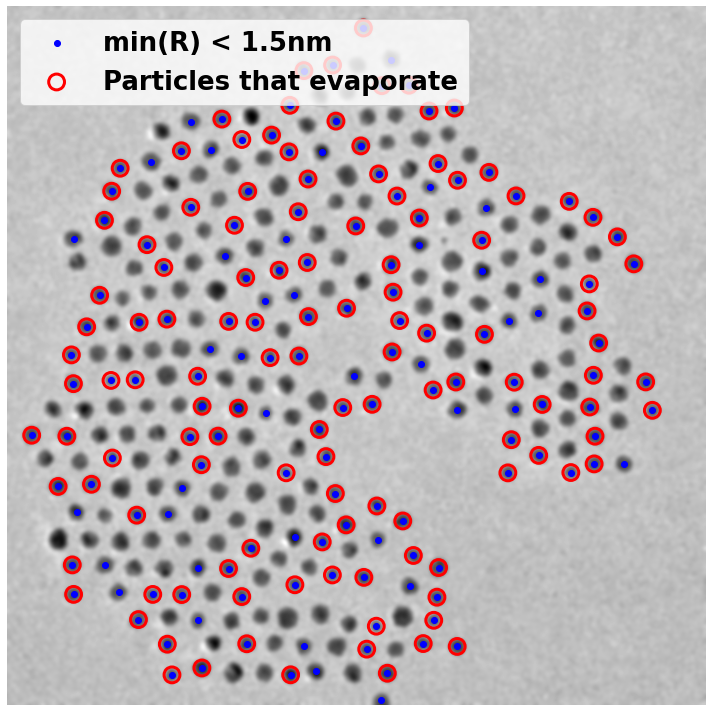

In [12]:
lessthan_x = []
lessthan_y = []
lessthan = []
greaterthan = []

evap_x = []
evap_y = []
evap = []
no_evap = []


for particle in particles.groups:
    p = particles.get_group(particle)
    if len(p) > 5:
        x = p['x'].iloc[0]
        y = p['y'].iloc[0]
        r = p['d']/2
        
        if np.min(r) < 1.5:
            lessthan_x.append(x)
            lessthan_y.append(y)
            lessthan.append(particle)
        else:
            greaterthan.append(particle)
            
        if len(p) < 590:
            evap_x.append(x)
            evap_y.append(y)
            evap.append(particle)
        else:
            no_evap.append(particle)
            
print(len(np.intersect1d(lessthan,evap)),len(evap),len(np.intersect1d(lessthan,evap))/len(evap))
            
f,a = plt.subplots(figsize=(10,10))
a.imshow(images[0],plt.cm.gray)
a.axis('off')

a.scatter(lessthan_x,lessthan_y,color='blue',label='min(R) < 1.5nm')
a.scatter(evap_x,evap_y,edgecolor='red',facecolor='none',s=250,linewidth=3,label='Particles that evaporate')
legend_properties = {'weight':'bold',
                     'size':26,
                    }
a.legend(prop=legend_properties,loc='upper left')
plt.tight_layout()


Text(0, 0.5, 'Recall')

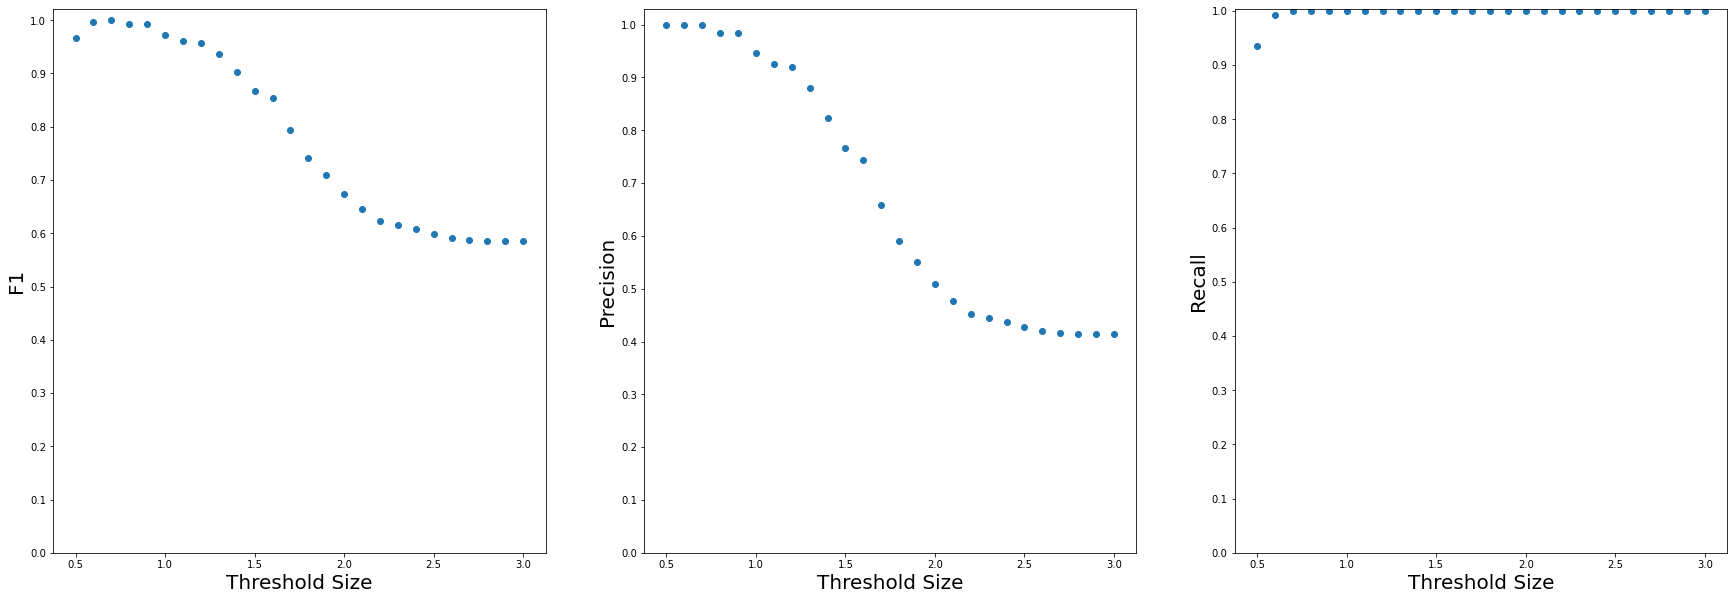

In [13]:
percents = []
sizes = []
F1s = []
precision = []
recall = []

for size in np.arange(0.5,3.1,0.1):
    lessthan = []
    greaterthan = []
    evap = []
    no_evap = []
    all_p = []
    for particle in particles.groups:
        p = particles.get_group(particle)
        if len(p) > 5:
            x = p['x'].iloc[0]
            y = p['y'].iloc[0]
            r = p['d']/2
            
            if np.min(r) < size:
                lessthan.append(particle)
            else:
                greaterthan.append(particle)
                
            if len(p) < 590:
                evap.append(particle)
            else:
                no_evap.append(particle)
                
            all_p.append(particle)
                
    total = len(lessthan) + len(evap) + len(no_evap) + len(greaterthan)
    tp = len(np.intersect1d(lessthan,evap))
    tn = len(np.intersect1d(greaterthan,no_evap))
    fp = len(np.intersect1d(lessthan,no_evap))
    fn = len(np.intersect1d(greaterthan,evap))
    
    F1 = tp / (tp + 0.5 * (fp + fn))
    
    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))
    sizes.append(size)
    F1s.append(F1)
    
    
    
    
    
    
f,a = plt.subplots(figsize=(30,10),ncols=3)
a[0].scatter(sizes,F1s)
a[0].set_yticks(np.arange(0,1.1,0.1))
a[0].set_xlabel('Threshold Size',fontsize=20)
a[0].set_ylabel('F1',fontsize=20)

a[1].scatter(sizes,precision)
a[1].set_yticks(np.arange(0,1.1,0.1))
a[1].set_xlabel('Threshold Size',fontsize=20)
a[1].set_ylabel('Precision',fontsize=20)

a[2].scatter(sizes,recall)
a[2].set_yticks(np.arange(0,1.1,0.1))
a[2].set_xlabel('Threshold Size',fontsize=20)
a[2].set_ylabel('Recall',fontsize=20)

In [14]:
lessthan = []
greaterthan = []
evap = []
no_evap = []
all_p = []
for particle in particles.groups:
    p = particles.get_group(particle)
    if len(p) > 5:
        x = p['x'].iloc[0]
        y = p['y'].iloc[0]
        r = p['d']/2
        
        if np.min(r) < 1.5:
            lessthan.append(particle)
        else:
            greaterthan.append(particle)
            
        if len(p) < 590:
            evap.append(particle)
        else:
            no_evap.append(particle)
            
        all_p.append(particle)
            


truth = np.zeros((len(evap)+len(no_evap),1))
pred = np.zeros_like(truth)

for i in evap:
    truth[np.where(np.array(all_p)[:] == i)] = 1
    
for i in lessthan:
    pred[np.where(np.array(all_p)[:] == i)] = 1
    
cm = confusion_matrix(truth,pred)
print(cm)

[[139  38]
 [  0 125]]


### Figure 4 and Supplemental Figure 3

Figure 4 concerns a set of 3 particles interact via surface diffusion.  The following code shows how to collect information on specific particles, fit these particles to the model, and observe their parameter values.  In order to understand how the concentraion gradient and capillary length differ for particles that shirnk and don't shrink, the model was constrained to take mean values for all other parameters such that only concentration- and capillarity-related parameters can be varied

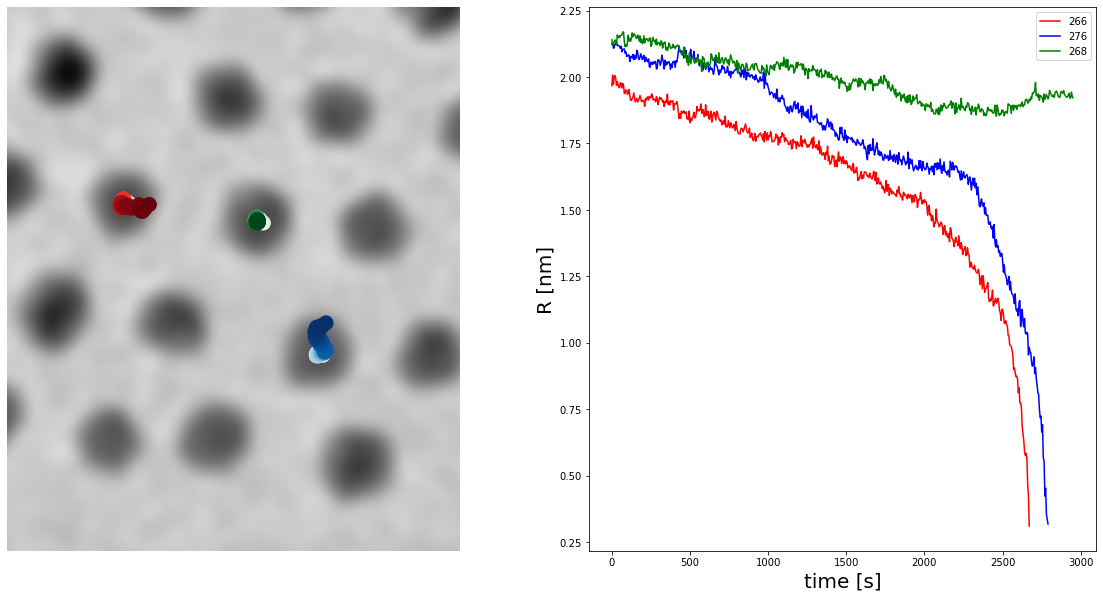

In [15]:
particle_set = [266,276,268]

y_min = 0
y_max = 900
x_min = 1300
x_max = 2000

f,a = plt.subplots(figsize=(20,10),ncols=2)
a[0].imshow(images[0],plt.cm.gray)
a[0].set_xlim([x_min+100,x_max-100])
a[0].set_ylim([y_min+150,y_max-150])
a[0].axis('off')


colors = plt.cm.tab10(np.linspace(0,1,10))
particles = info_linked.groupby('particle')


cmaps= ['Reds','Blues','Greens']
colors=['red','blue','green']


n = 0
for particle in particle_set:
    p = particles.get_group(particle)
    a[0].scatter(p['x'],p['y'],c=p['frame'],s=200,cmap=cmaps[n],label='{}'.format(particle))
    a[1].plot(p['time'],p['d']/2,color=colors[n],label=particle)
    
    p = particles.get_group(particle)
    r = np.array(p['d'])[1:] / 2
    r0 = p['d'].iloc[0] / 2
    t = np.array(p['time'])[1:]
    less2 = np.where(r[:] < 1.8)[0]
    t500 = np.where(t[:] > 1000)[0]
    less1 = np.where(r[:] < 1)[0]
    drdt = (r - r0) / t
    
    n += 1
    
a[1].set_xlabel('time [s]',fontsize=20)
a[1].set_ylabel('R [nm]',fontsize=20)
a[1].legend()

5.7777355247434095 76.14792821106661


[]

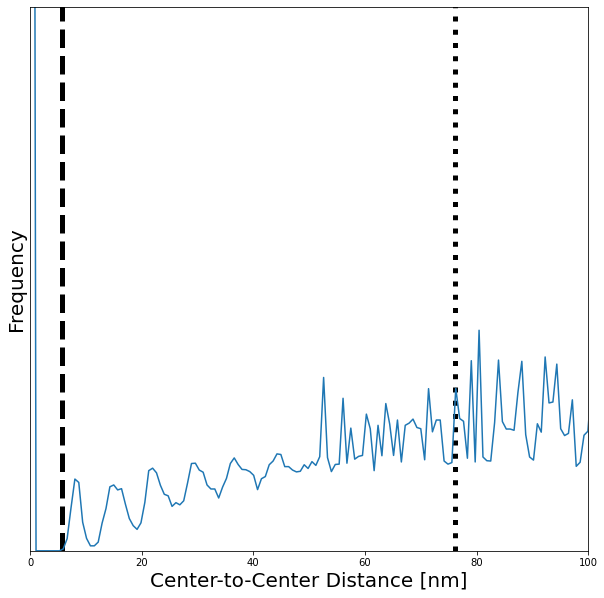

In [16]:
xi_range = params_array[:,-1]
mz,thresh_loc = modified_z(xi_range,3.5)

low_mean_xi = np.mean(xi_range[mz[:] < 3.5])
high_mean_xi = np.mean(xi_range[mz[:] > 3.5])

print(low_mean_xi,high_mean_xi)


times = info_linked.groupby('time')
t0 = times.get_group(0)  ### Only look at data from t = 0
particles_t0 = t0.groupby('particle')

total_distance = []

for particle in particles_t0.groups:
    p = particles_t0.get_group(particle) ## Get info from t = 0
    x = np.float(p['x'])
    y = np.float(p['y'])
    
    dx = np.array(t0['x']).reshape(-1,1) - x
    dy = np.array(t0['y']).reshape(-1,1) - y
    distance = np.sqrt(dx ** 2 + dy ** 2) * 0.057 ## This gives you the distances that you plotted (for each particle)
    
    total_distance.append(distance)
    
dist0 = np.array(total_distance).reshape(-1,1)

f,a = plt.subplots(figsize=(10,10))

xi1_pix = low_mean_xi / 0.057
xi2_pix = high_mean_xi / 0.057

counts, edges = np.histogram(dist0,bins=300)
centers = (edges[1:] + edges[:-1]) / 2
a.plot(centers,counts)
a.set_xlabel('Center-to-Center Distance [nm]',fontsize=20)
a.set_ylabel('Frequency',fontsize=20)
a.vlines([low_mean_xi,high_mean_xi],0,4000,colors=['black'],linestyles=['dashed','dotted'],linewidths=[5])
a.set_xlim([0,100])
a.set_ylim([0,3500])
a.set_yticks([])

In [17]:
A1_mean = 97.652
A4_mean = 0.001
A5_mean = -3.018
theta_mean = 2.3
xi_mean = 6.514

def model_constrained(r,A2,A3):
    arg = r * np.sin(theta_mean) / xi_mean
    k1 = special.kn(1,arg)
    k0 = special.kn(0,arg)

    return A1_mean * (np.sin(theta_mean)) / (xi_mean * alpha(theta_mean) * r) * (k1 / k0) * (A2 + A3 / (r * np.sin(theta_mean))) + A4_mean * beta(theta_mean) / alpha(theta_mean) * (1 + A5_mean / r)

def residuals_constrained(params,x,y):
    return model_constrained(x,*params) - y

################### Parameter Bounds ##########################

A2_low = -np.inf 
A2_high = np.inf # 0

A3_low = -np.inf
A3_high =  0# 0

x0 = [10,-1]

bounds = ([A2_low,A3_low],[A2_high,A3_high])
##################################################################
n = 0
color = ['Red','Blue','Green']

for particle in particle_set:
    p = particles.get_group(particle)
    r = np.array(p['d']/2)
    t = np.array(p['time'])
    
    time_cutoff = int(800 / 5)
    
    w = np.ones_like(t)
    w[0] = 10
    w[-1] = 10
    w[time_cutoff:] = 2
    spl = UnivariateSpline(t,r,w=w,k=5,s=1)
    deriv = spl.derivative()
    
    fit = optimize.least_squares(residuals_constrained,x0=x0,args=(spl(t[time_cutoff:]),deriv(t[time_cutoff:])),bounds=bounds,max_nfev=10000,verbose=0,xtol=None,loss='linear')
    print('{}'.format(color[n]))
    print('\t',fit.x)
    print('\n\n')
    n += 1

Red
	 [ 0.00095683 -0.00011654]



Blue
	 [ 8.56445831e-04 -8.56814648e-05]



Green
	 [ 7.67468096e-04 -3.75854207e-09]





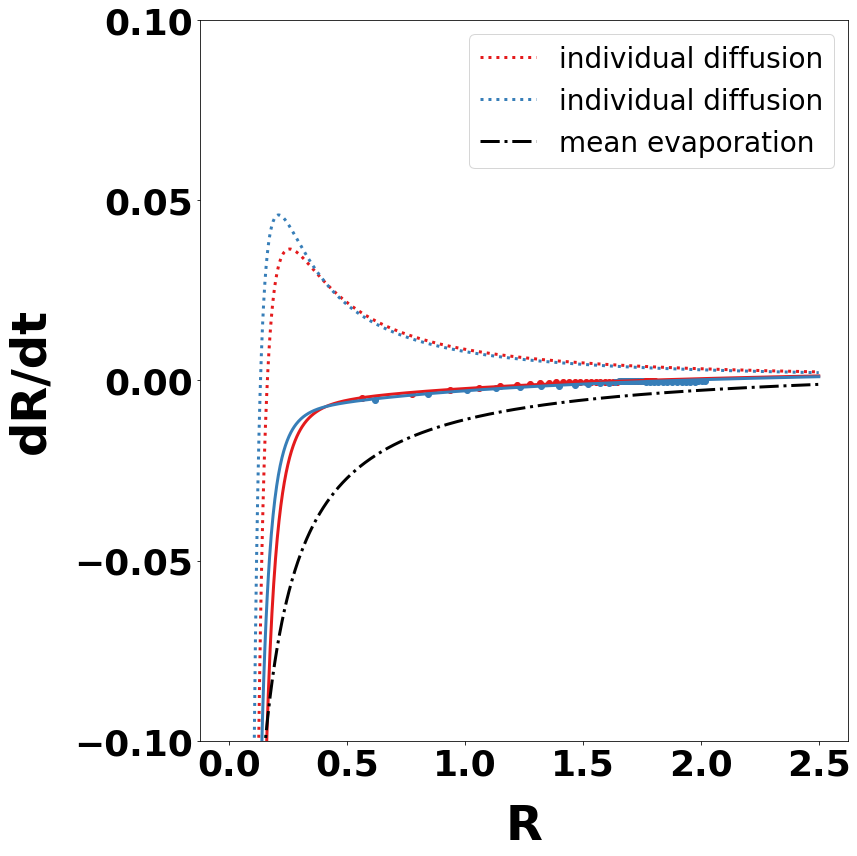

In [18]:
f,a = plt.subplots(figsize=(12,12))
colors = plt.cm.Set1(np.linspace(0,1,9))
n = 0

for particle in [266,276]:
    p = particles.get_group(particle)
    r = np.array(p['d']/2)
    t = np.array(p['time'])
    
    time_cutoff = int(800 / 5)
    
    w = np.ones_like(t)
    w[0] = 10
    w[-1] = 10
    w[time_cutoff:] = 2
    spl = UnivariateSpline(t,r,w=w,k=5,s=1)
    deriv = spl.derivative()
    
    fit = optimize.least_squares(residuals_constrained,x0=x0,args=(spl(t[time_cutoff:]),deriv(t[time_cutoff:])),bounds=bounds,max_nfev=10000,verbose=0,xtol=None,loss='linear')

    
    x = np.linspace(0,2.5,1000)[1:]
    
    a.scatter(spl(t[time_cutoff::10]),deriv(t[time_cutoff::10]),color=colors[n])
    a.plot(x,model_constrained(x,*fit.x),color=colors[n],linewidth=3)
    a.plot(x,dRdt_diff(x,A1_mean,*fit.x,theta_mean,xi_mean),':',color=colors[n],linewidth=3,label='individual diffusion')
    n += 1
    
a.plot(x,dRdt_evap(x,A4_mean,A5_mean,theta_mean),linestyle='dashdot',color='black',linewidth=3,label='mean evaporation')

    
a.set_ylim([-10e-2,10e-2])
a.legend(fontsize=28)
a.set_xlabel('R',fontsize=48,fontweight='bold',labelpad=20)
a.set_yticks(np.arange(-0.1,0.11,0.05))
a.set_ylabel('dR/dt',fontsize=48,fontweight='bold',labelpad=20)
a.tick_params(axis='both',labelsize=36)

for tick in a.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in a.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    
    
plt.tight_layout()